## Detecting Human Posture Using a Convolutional Deep Neural Network

### Tensorflow Implementation

Authors: Tiffany J Munn (tiffany.munn@du.edu)* and Tai Chen Ye (tai-chen.ye@du.edu)*

*University of Denver: Department of Computer Science and Engineering

Last Update: August 27th, 2020

Note:
Many functions used in the code below were repurposed from:
https://github.com/rasbt/python-machine-learning-book-3rd-edition Copyright (c) 2019 Sebastian Raschka

In [1]:
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import pathlib
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Experiment Objective

Create a deep learning neural network that can detect human posture from silhouettes. This dataset contains 1200 images for each of the following postures:

    1. Sitting
    2. Standing
    3. Bending
    4. Lying
    
The dataset comes with each image resized to the dimension of 512x512 px. Images have not been labeled directly but have been placed in respective class folders based off the posture in the image.

### Data Collection and Preprocessing

Source: https://ieee-dataport.org/open-access/silhouettes-human-posture-recognition
License: Creative Commons Attribution
Details on the Terms of Use for this License: https://creativecommons.org/licenses/by/4.0/ and 
https://creativecommons.org/licenses/by/4.0/legalcode

About IEEE Dataport

"IEEE developed IEEE DataPort to provide significant benefits to researchers, data analysts, and the global technical community. The platform offers free uploads of any dataset up to 2TB for those that need to retain and manage their valuable research data and it offers free access to the datasets on IEEE DataPort. The platform currently has over 425,000 global users and over 1,500 datasets and continues to provide value to researchers around the globe."

I was required to create an account and agree to terms of use (https://creativecommons.org/licenses/by/4.0/) before being able to download the archive for free.

Authors of Dataset: 
Abhishek Kumar (Indian Institute of Information Technology Kottayam) and Ebin Deni Raj (Indian Institute of Information Technology Kottayam)

Note:
Many functions used in the code below were repurposed from:
https://github.com/rasbt/python-machine-learning-book-3rd-edition Copyright (c) 2019 Sebastian Raschka

#### Creating an Input Pipeline

#### Saving Image File List

In [2]:
import pathlib
data_dir = pathlib.Path('../Project03/Postures')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total Image Count: {image_czzount}')

Total Image Count: 4800


#### Creating Train and Validation Arrays

In [3]:
from sklearn.model_selection import train_test_split
X= np.array(sorted([str(path) for path in data_dir.glob('*/*.jpg')]))
y = np.array([0 if 'bending' in file 
          else 1 if 'lying' in file
          else 2 if 'sitting' in file
          else 3
          for file in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1, shuffle=True)

#### Visualizing Our Training Data

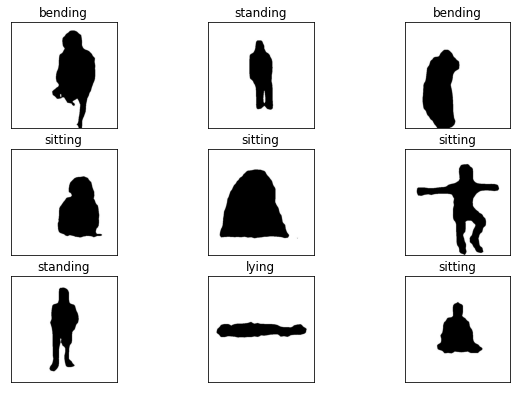

In [4]:
X_train_example=X_train[:9]
y_train_example=y_train[:9]
labels_dict={0: 'bending', 1:'lying', 2: 'sitting', 3: 'standing'}

fig = plt.figure(figsize=(10, 10))
for i,file, in enumerate(X_train_example):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(labels_dict[y_train_example[i]], size=12)
    plt.subplots_adjust(top=1.5, bottom=1)
    
plt.show()

#### Functions to Generate Batched Tensorflow Datasets from Arrays

In [14]:
def load_and_preprocess(paths):
    images=[]
    for path in paths:
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, [64, 64])
        #this is a pixel normalization step
        image /= 255.0
        images.append(image)
    return images

def train_input_fn(x_train, y_train, batch_size):
    x_train=load_and_preprocess(x_train)
    dataset = tf.data.Dataset.from_tensor_slices(
        ({'input-features':x_train}, y_train.reshape(-1, 1)))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(100).repeat().batch(batch_size)

def eval_input_fn(x_test, y_test, batch_size):
    x_test=load_and_preprocess(x_test)
    if y_test is None:
        dataset = tf.data.Dataset.from_tensor_slices(
            {'input-features':x_test})   
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input-features':x_test}, y_test.reshape(-1, 1)))

    # Shuffle, repeat, and batch the examples.
    return dataset.batch(batch_size)


#### Demonstrating that Functions Do Output Tensorflow DS Batches

In [15]:
batch_size = 32
demo_train=train_input_fn(X_train, y_train, batch_size)
demo_val=eval_input_fn(X_test, y_test, batch_size)

print(demo_train, '\n', demo_val)

<BatchDataset shapes: ({input-features: (None, 64, 64, 1)}, (None, 1)), types: ({input-features: tf.float32}, tf.int64)> 
 <BatchDataset shapes: ({input-features: (None, 64, 64, 1)}, (None, 1)), types: ({input-features: tf.float32}, tf.int64)>


### TensorFlow Model Creation

#### Explaining Our Hyper-Parameter Choices

#### Keras Initializers
First, there are many Layer weight initializers in kernel_initializer. For example, the RandomNormal class generates tensors with a normal distribution.TruncatedNormal type makes a truncated normal distribution. Because the first step of rescaling value from 0 to 1, we should use the normal distribution or something very similar. Based on current standards for deep NN, we use Glorot Initialization. It initializes each weight with a small Gaussian value with mean=0 and variances are based on the fan-in and fan-out of the weight. This is the default for tf.keras.layers.Conv2D layers.

Second, there are many Layer weight initializers in bias_initializer.In this part, we choose the Zeros class in the convolutional layers, which is the default.

#### Keras Regularizers
There are three methods in Keras Regularizers: L2(Ridge), L1(LASSO) and L1L2(Elastic Net regularization) First, L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients.L2 regularization adds an L2 penalty equal to the square of the significance of coefficients. Elastic nets combine L1 & L2 methods.
Second, applying L1 regularization does lead to models where the weights will get relatively small values, where they are simple. This is similar to using L2 regularization. However, contrary to L2, L1 regularization does not push your weights to be precisely zero. In other words, the L2 method could not be used in variable selection.
Third, applying the L2 method could solve the multicollinearity problem Ridge Regression has n-dimension. Still, Lasso yields fewer dimensions comparatively, with very less decrease inaccuracy, which is suitable for building a production model.
Therefore, L1L2(Elastic Net regularization) is the best method to combines these two methods: a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms.

However, in practice we found that L2 regularization was more accurate than L1L2 and therefore implemented L2 regularization in our dense layers.

#### Activations
The activation function is between the input feeding the current neuron and its output going to the next layer.
There are many non-linear activation functions like Sigmoid, tanh, ReLU, Leaky ReLU, Parametric ReLU, softmax, Swish.

Typically, if we want to solve the classification problems, we could use the Sigmoid functions. However, Sigmoid functions have a problem when the vanishing gradient problem.

Second, if the neural network has a dead neuron problem, Tanh functions would not work properly.

Third, the ReLU activation function is widely used and is a default choice as it yields better results and functions well in hidden layers. Also, if the neural network exists in a case of dead neurons, leaky ReLU function could solve this problem.
Finally, The ReLU method is, as of 2017, the most popular activation function for deep neural networks.
Therefore, we implement the ReLU parameter in our convolutional and dense layers.

#### Kernel Size
We choose to use the kernel size (3,3) as it is standard for CNN. Another standard is 5X5 but in general it is good to start with a smaller kernel and work up if needed.

#### Padding and Pooling

To preserve the size of the height and width of the input images, we choose padding='same'. Then we decrease the spatial size using pooling layers as opposed to using valid padding which would decrease the volume of tensors in our NN.

#### Strides
Strides choosen was (1, 1) as a starting value. Further experimentation should be done to determine if this is the optimal value.

#### Optimizer
The adam optimizer is an extension to stochastic gradient descent and has been commonly adopted by many researchers for use in DNNs. In a paper titled “An overview of gradient descent optimization algorithms”, (https://arxiv.org/abs/1609.04747) Sebastian Ruder's says:

    "Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. […] its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice."


#### Loss Function

Since our model deals with 4 classes, we implemented tf.keras.losses.SparseCategoricalCrossentropy in our compile method.

#### Depth and Width of NN

To prevent over-fitting, the depth of our first layer starts with filters=8 and builds up by power of 2 in each convolutional layer. We then flatten our data to reduce the width of the output. Two dense layers are added with decreasing units and a dropout layer in between. This again, helps to decrease our output width. This approach helps to deepen the input and reduce the width of the output of the NN.

In [16]:
#Define the feature columns
features = [tf.feature_column.numeric_column(key='input-features:', shape=(64, 64, 1))]
    
features

[NumericColumn(key='input-features:', shape=(64, 64, 1), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [25]:
num_classes = 4

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64,64,1), name='input-features'),
    tf.keras.layers.Conv2D(filters=8,strides=(1, 1), kernel_size=(3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=16, strides=(1, 1), kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(units=num_classes, activation='relu')
])


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','categorical_accuracy'])

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)             

### TensorFlow Estimator Creation and Training

In [28]:
my_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir='models/estimator-for-Postures/')


# use the estimator: train/evaluate/predict

num_epochs = 15
batch_size = 32
steps_per_epoch = np.ceil(len(X_train) / batch_size)

my_estimator.train(
    input_fn=lambda: train_input_fn(X_train, y_train, batch_size),steps=num_epochs * steps_per_epoch)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'models/estimator-for-Postures/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done 

### TensorFlow Estimator Performance Evaluation

In [29]:
my_estimator.evaluate(
    input_fn=lambda: eval_input_fn(X_test, y_test, batch_size))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:13:52Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/estimator-for-Postures/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 7.83873s
INFO:tensorflow:Finished evaluation at 2020-08-23-05:14:00
INFO:tensorflow:Saving dict for global step 1800: accuracy = 0.9145833, categorical_accuracy = 0.25729167, global_step = 1800, loss = 0.38916188
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1800: models/estimator-for-Postures/model.ckpt-1800


{'accuracy': 0.9145833,
 'categorical_accuracy': 0.25729167,
 'loss': 0.38916188,
 'global_step': 1800}

### TensorFlow Model Performance Evaluation and Visualization

Using the same model as before, but declaring it again because calling the same instance of the model after it has been converted to an estimator causes an error.

In [45]:
num_classes = 4

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64,64,1), name='input-features'),
    tf.keras.layers.Conv2D(filters=8,strides=(1, 1), kernel_size=(3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=16, strides=(1, 1), kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(units=num_classes, activation='relu')
])


In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','categorical_accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)             

In [47]:
BATCH_SIZE = 32
NUM_EPOCHS = 15
TRAINING_SIZE=3840

steps_per_epoch = np.ceil(TRAINING_SIZE / BATCH_SIZE)

history=model.fit(demo_train, validation_data=demo_val, 
                 epochs=NUM_EPOCHS,steps_per_epoch=steps_per_epoch, batch_size=BATCH_SIZE)

Epoch 1/15
120/120 [==============================] - 5s 39ms/step - loss: 1.4228 - accuracy: 0.4940 - categorical_accuracy: 0.4190 - val_loss: 1.0535 - val_accuracy: 0.6281 - val_categorical_accuracy: 0.3750
Epoch 2/15
120/120 [==============================] - 4s 34ms/step - loss: 1.0207 - accuracy: 0.6208 - categorical_accuracy: 0.3810 - val_loss: 0.8915 - val_accuracy: 0.6625 - val_categorical_accuracy: 0.3760
Epoch 3/15
120/120 [==============================] - 4s 35ms/step - loss: 0.8907 - accuracy: 0.6534 - categorical_accuracy: 0.3865 - val_loss: 0.7950 - val_accuracy: 0.6792 - val_categorical_accuracy: 0.4260
Epoch 4/15
120/120 [==============================] - 4s 34ms/step - loss: 0.7803 - accuracy: 0.7781 - categorical_accuracy: 0.3221 - val_loss: 0.6245 - val_accuracy: 0.8708 - val_categorical_accuracy: 0.2479
Epoch 5/15
120/120 [==============================] - 4s 34ms/step - loss: 0.6595 - accuracy: 0.8302 - categorical_accuracy: 0.2570 - val_loss: 0.5341 - val_accurac

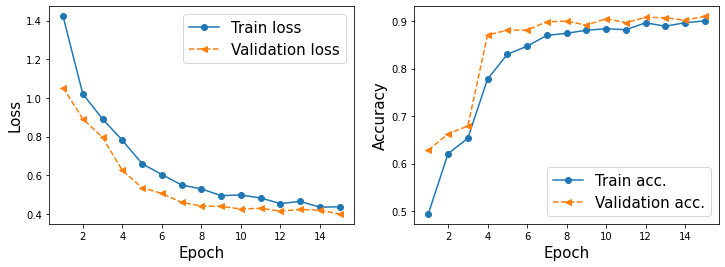

In [48]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_18.png', dpi=300)
plt.show()

### Results

Using epochs=15, and batch size=32, we were able to achieve a 91.5% accuracy on our validation data with our custom estimator. Therefore, our CNN was able to successfully classify human silhouette photos with 91.5% accuracy.

With the same parameters and data, we re-ran our model using fit instead of the estimator and found very similar results with validation accuracy of 91% and a training accuracy of 90%.

After about epoch 15, overfitting begins to occur. The graph of accuracy above extrapolated further would clearly indicate overfitting, so we stop at 15.

Overall, our model performs well, but further tuning of the hyperparameters in each layer of the CNN should help to increase accuracy on new data. 